In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import r2_score
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Define the neural network
class DiffEqNN(tf.keras.Model):
    def __init__(self):
        super(DiffEqNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(5, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(10, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(5, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(2)  # Two outputs: u(x) and T(x)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

In [5]:
# Define the differential equations and loss function
def loss_fn(model, x):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            u_T = model(x)
            u = u_T[:, 0:1]
            T = u_T[:, 1:2]
        
        u_x = tape1.gradient(u, x)
        T_x = tape1.gradient(T, x)
    
    u_xx = tape2.gradient(u_x, x)
    T_xx = tape2.gradient(T_x, x)
    
    # Define the differential equations
    eq1 = -(1 / (1 + x)) * (u_x - T) + u_xx - T_x
    eq2 = -(1 / (1 + x)) * T_x + T_xx
    
    # Boundary conditions
    u_0 = model(tf.constant([[0.0]]))[:, 0:1]
    u_1 = model(tf.constant([[1.0]]))[:, 0:1]
    T_0 = model(tf.constant([[0.0]]))[:, 1:2]
    T_1 = model(tf.constant([[1.0]]))[:, 1:2]
    
    bc_u = tf.square(u_0) + tf.square(u_1-1)
    bc_T = tf.square(T_0) + tf.square(T_1 - 1)
    
    # Total loss
    loss = tf.reduce_mean(tf.square(eq1) + tf.square(eq2) + bc_u + bc_T)
    
    return loss

In [6]:
# Training
model = DiffEqNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

x_train = np.linspace(0, 1, 100).reshape(-1, 1).astype(np.float32)

losses = []
for i in range(1500):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x_train)
        losses.append(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss}")

Iteration 0, Loss: 1.9853118658065796
Iteration 100, Loss: 0.6566598415374756
Iteration 200, Loss: 0.5923749804496765
Iteration 300, Loss: 0.5334473252296448
Iteration 400, Loss: 0.4041171371936798
Iteration 500, Loss: 0.09472092986106873
Iteration 600, Loss: 0.057361993938684464
Iteration 700, Loss: 0.039139918982982635
Iteration 800, Loss: 0.026775266975164413
Iteration 900, Loss: 0.014136232435703278
Iteration 1000, Loss: 0.004790135193616152
Iteration 1100, Loss: 0.0023061439860612154
Iteration 1200, Loss: 0.0015523534966632724
Iteration 1300, Loss: 0.001181159052066505
Iteration 1400, Loss: 0.0009686946868896484


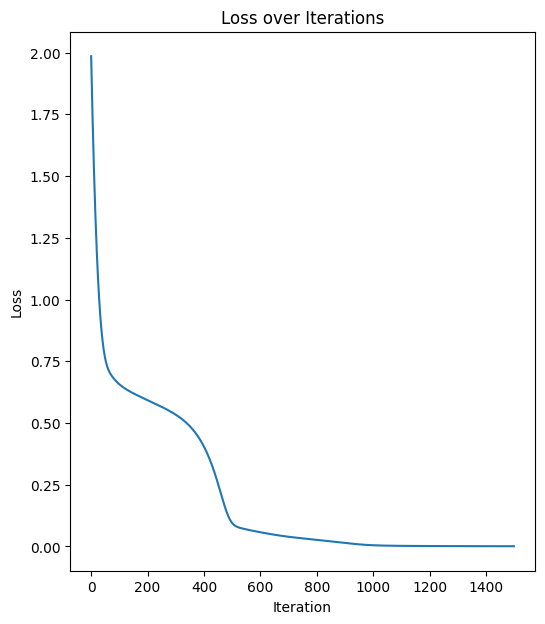

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
r2 score for u 0.9422730094813159
r2 score for T 0.999961932813693


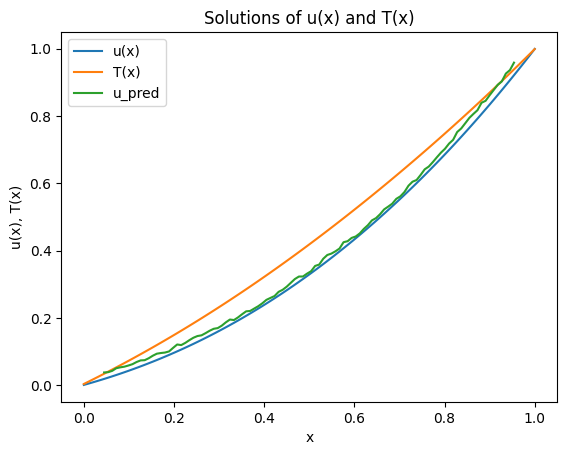

In [10]:
# Plotting the loss over iterations
plt.figure(figsize = (6,7))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

# Plot the solution
x_test = np.linspace(0, 1, 100).reshape(-1, 1).astype(np.float32)
u_T_pred = model.predict(x_test)

u_pred = u_T_pred[:, 0]
T_pred = u_T_pred[:, 1]

true_u = (x_test**3)/3 + (14/27)*(x_test)**2 + (10/27)*x_test
true_T = (2/3)*x_test + (1/3)*(x_test)**2 

r2_u = r2_score(true_u, u_pred)
print('r2 score for u',r2_u)

r2_T = r2_score(true_T, T_pred)
print('r2 score for T',r2_T)

import pandas as pd
df = pd.read_csv('temp_dis.csv')

x_data = df.iloc[:, 0]  # First column for x values
u_pred_data = df.iloc[:, 1]  # Second column for u_pred values (y values)

# Plotting multiple lines on the same graph
plt.plot(x_test, u_pred, label='u(x)')
plt.plot(x_test, T_pred, label='T(x)')
plt.plot(x_data, u_pred_data, label='u_pred')
plt.xlabel('x')
plt.ylabel('u(x), T(x)')
plt.title('Solutions of u(x) and T(x)')
plt.legend()
plt.show()